In [31]:
# @title
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 18px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)


# Simple Convolution Neural Network (CNN) in JAX, Flax


## What is JAX/Flax?

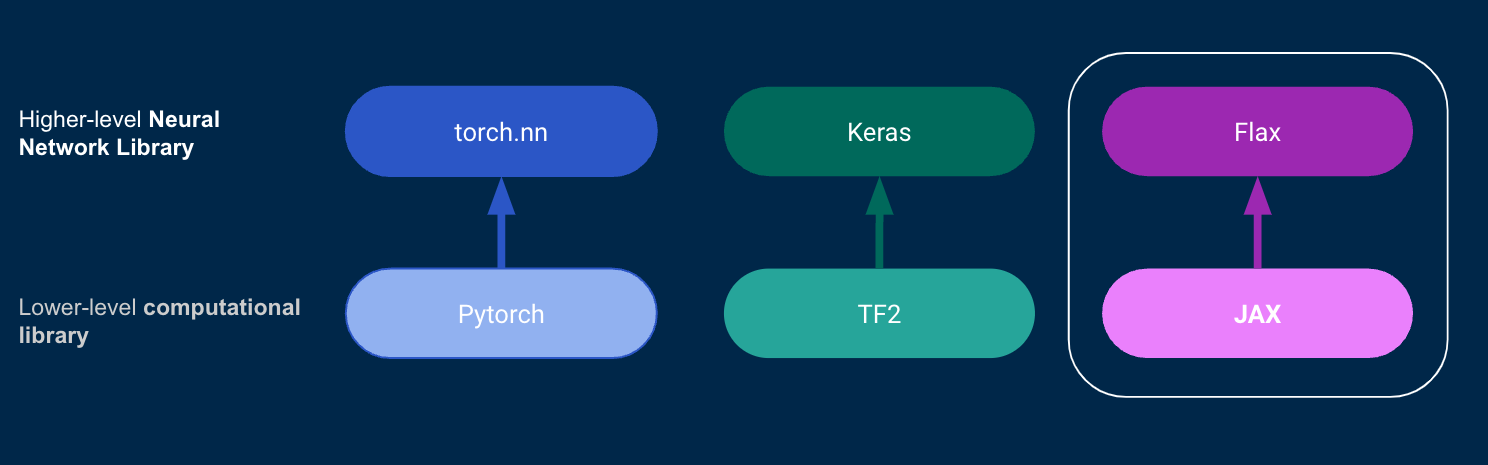

## We'll build a CNN to classify MNIST digits using JAX, Flax!

In [32]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state  # Useful dataclass to keep train state
import optax

## Dataset pipline

In [33]:
import tensorflow as tf

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel values.
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert the labels to one-hot encoding.
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [34]:
def create_dataset(input_image_tensors, label_tensors):
  dataset = (
      tf.data.Dataset
      .from_tensor_slices((input_image_tensors, label_tensors))
      .shuffle(buffer_size=5000)
      .batch(64)
      .repeat()
      .prefetch(tf.data.AUTOTUNE)
      .as_numpy_iterator())
  return dataset

def get_batch(dataset):
  images, labels = next(dataset)
  images, labels = jnp.array(images), jnp.array(labels, dtype=jnp.int32)
  images = jnp.expand_dims(images, axis=-1)
  return images, labels

In [35]:
# Create a tf.data pipeline for the train and test set.
train_dataset = create_dataset(x_train, y_train)
test_dataset = create_dataset(x_test, y_test)

### Let's test fetching a batch...

In [36]:
images_batch, labels_batch = get_batch(train_dataset)
single_image, single_label = images_batch[0], labels_batch[0]

In [37]:
single_label

Array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

## Modeling

In [38]:
import flax.linen as nn

class Model(nn.Module):
  def setup(self):
    # 28x28x1 -> 14x14x16
    self.conv1 =  nn.Conv(16, kernel_size=(3, 3), strides=(2, 2))

    # 14x14x16 -> 7x7x8
    self.conv2 = nn.Conv(8, kernel_size=(3, 3), strides=(2, 2))

    # 7x7x8 -> 4x4x4
    self.conv3 = nn.Conv(4, kernel_size=(3, 3), strides=(2, 2))

    # 4x4x4 -> 2x2x1
    self.conv4 = nn.Conv(1, kernel_size=(3, 3), strides=(2, 2))

    self.final_layer = nn.Dense(10)

  def __call__(self, x):
    x = nn.relu(self.conv1(x))
    x = nn.relu(self.conv2(x))
    x = nn.relu(self.conv3(x))
    x = nn.relu(self.conv4(x))

    # flatten
    batch_size = x.shape[0]
    x = x.reshape(batch_size, -1)

    x = self.final_layer(x)
    return x

## How to implement training Loop in Flax


In [39]:
# JAX functions need to be **state-less!

In [40]:
# Initialize the model using `model.init`, the function returns the model params.
model = Model()
params = model.init(jax.random.PRNGKey(99), images_batch)
params = params["params"]

In [41]:
# @title
params

{'conv1': {'kernel': Array([[[[ 0.10318059, -0.36546168,  0.10348582, -0.18727979,
            -0.2989344 , -0.06120202, -0.30305564, -0.06325838,
            -0.47007623,  0.00182239,  0.08036909, -0.28868243,
            -0.1755667 , -0.46929264,  0.22673424,  0.1213199 ]],
  
          [[-0.00159304, -0.06865791, -0.48096153,  0.5176608 ,
            -0.24610692,  0.12146369,  0.31982005,  0.19794294,
            -0.4636128 ,  0.13819885, -0.17930195,  0.1044026 ,
            -0.54910463,  0.4998827 , -0.33488676,  0.5588218 ]],
  
          [[-0.01486812, -0.27757135,  0.65702665, -0.28058687,
            -0.37632743,  0.06171224,  0.63409156,  0.1940167 ,
             0.55188036,  0.35217246, -0.39919505, -0.42158285,
            -0.2778281 , -0.01271519, -0.72809803, -0.5164525 ]]],
  
  
         [[[ 0.05771004, -0.03288956, -0.14206718, -0.3323581 ,
            -0.17923449,  0.18122466,  0.72265977,  0.53838944,
            -0.19212681,  0.2795688 , -0.23983324,  0.0612007 ,
  

# Forward Pass in JAX

In [42]:
logits = model.apply({"params": params}, images_batch)

In [43]:
logits.shape

(64, 10)

## putting everything together into a concise forward pass function...

In [44]:
# Use TrainState to store all the state required during training.

In [45]:
state = train_state.TrainState.create(
    apply_fn=model.apply,  # forward pass func
    params=params,   # model weights
    tx=optax.adam(learning_rate=0.001)  # optimizer func
)

In [46]:
def forward_pass(params, state, batch):
  input_images, labels = batch

  # call forward pass function.
  logits = state.apply_fn({"params": params}, input_images)

  # compute loss
  loss = optax.softmax_cross_entropy(logits=logits, labels=labels)
  loss = loss.mean()
  return loss, logits

# Backward Pass in JAX

In [47]:
# First, we need to create a function to compute gradients.

In [48]:
# `argnums=(0)` says differentiate wrt 0th pos argument.

grad_fn = jax.grad(forward_pass, argnums=(0), has_aux=True)

In [49]:
grads, _ = grad_fn(state.params, state, (images_batch, labels_batch))

In [50]:
# Let's look at the grads.

In [51]:
grads

{'conv1': {'bias': Array([-0.00803536, -0.0024347 , -0.00238726, -0.00247244,  0.00073105,
         -0.01049255,  0.00067712, -0.00270273,  0.00216846,  0.0014786 ,
         -0.00056598,  0.00448007, -0.00013856, -0.00508694,  0.00091493,
         -0.00167487], dtype=float32),
  'kernel': Array([[[[ 1.21846981e-03,  2.90010270e-04, -7.34979461e-04,
            -1.35376788e-04,  0.00000000e+00, -6.83428114e-03,
             1.22212351e-03, -1.92325865e-03,  7.43371318e-04,
             4.30176361e-03,  1.34959031e-04,  1.75965438e-03,
            -9.36352808e-06, -1.63803692e-04, -1.75607728e-03,
            -5.26221411e-04]],
  
          [[ 3.63769475e-04,  6.28677197e-04,  2.52036611e-04,
            -2.64384202e-04, -1.31417536e-07, -6.64792862e-03,
             4.22214740e-04, -6.76118478e-04,  3.25096713e-04,
             1.80892646e-03,  1.00695754e-04,  6.67303568e-04,
             1.14414217e-06, -1.12379692e-03, -2.00295541e-03,
            -9.31623392e-04]],
  
          [[ 9

In [52]:
# To apply gradients, multiply grad * learning rate and subtract from model params.

In [53]:
# But we can just use the Flax's state.apply_gradients function to do so.

In [54]:
new_state = state.apply_gradients(grads=grads)

In [55]:
new_state

TrainState(step=1, apply_fn=<bound method Module.apply of Model()>, params={'conv1': {'bias': Array([ 0.00099999,  0.00099999,  0.00099999,  0.00099999, -0.00099998,
        0.00099999, -0.00099998,  0.00099999, -0.00099999, -0.00099999,
        0.00099998, -0.00099999,  0.00099992,  0.00099999, -0.00099998,
        0.00099999], dtype=float32), 'kernel': Array([[[[ 0.1021806 , -0.36646163,  0.10448579, -0.18627988,
          -0.2989344 , -0.06020203, -0.30405563, -0.06225839,
          -0.47107622,  0.0008224 ,  0.07936917, -0.28968242,
          -0.17456777, -0.4682927 ,  0.22773422,  0.12231987]],

        [[-0.002593  , -0.06965789, -0.4819615 ,  0.5186607 ,
          -0.24517764,  0.12246368,  0.3188201 ,  0.19894291,
          -0.46461275,  0.13719887, -0.18030185,  0.10340262,
          -0.550096  ,  0.5008827 , -0.33388677,  0.5598218 ]],

        [[-0.01586801, -0.27657136,  0.65802664, -0.2815868 ,
          -0.37532783,  0.06271223,  0.63509154,  0.19301674,
           0.5508

## putting everything together into a backward pass function...

In [56]:
def backward_pass(state, batch):
  # create a function to compute gradients wrt to loss
  # returned by our `forward_pass` function.
  grad_fn = jax.value_and_grad(forward_pass, argnums=(0), has_aux=True)

  # compute gradients.
  (loss, _), grads = grad_fn(state.params, state, batch)

  # apply gradients.
  state = state.apply_gradients(grads=grads)

  return state, loss

# Finally, we package forward_pass and backward_pass functions into a train_step and eval_step funciton

In [57]:
def train_step(state, batch):
  return backward_pass(state, batch)

In [58]:
def eval_step(state, batch):
  _, labels = batch

  # do forward pass.
  loss, logits = forward_pass(state.params, state, batch)

  # calculate accuracy of prediction over eval dataset.
  pred_labels = jnp.argmax(nn.softmax(logits), axis=-1)

  labels = jnp.argmax(labels, axis=-1)
  acc = jnp.mean(labels == pred_labels)

  return loss, acc

In [59]:
train_step = jax.jit(train_step)
eval_step = jax.jit(eval_step)

In [ ]:
# Train for 5000 steps
for step in range(5000):
  # get a minibatch of data.
  train_batch = get_batch(train_dataset)

  # run training over minibatch.
  state, loss = train_step(state, train_batch)

  # for ever 500 steps, run eval and print loss.
  if step%500==0:
    eval_batch = get_batch(test_dataset)
    eval_loss, eval_acc = eval_step(state, eval_batch)
    print("train_loss:", loss, "\teval loss:", eval_loss, "\teval acc:", eval_acc*100)

train_loss: 2.2960002 	eval loss: 2.273335 	eval acc: 25.0
train_loss: 1.9526949 	eval loss: 2.0955396 	eval acc: 12.5
train_loss: 1.8506072 	eval loss: 1.9026523 	eval acc: 28.125
train_loss: 1.5680823 	eval loss: 1.6920879 	eval acc: 37.5
train_loss: 1.5154871 	eval loss: 1.4237952 	eval acc: 48.4375
train_loss: 1.5429451 	eval loss: 1.5124483 	eval acc: 48.4375
train_loss: 1.5031788 	eval loss: 1.4713552 	eval acc: 48.4375
train_loss: 1.429775 	eval loss: 1.2027897 	eval acc: 64.0625
train_loss: 1.147381 	eval loss: 1.0880206 	eval acc: 65.625
train_loss: 0.834448 	eval loss: 1.1767831 	eval acc: 70.3125
train_loss: 0.85161215 	eval loss: 0.9639064 	eval acc: 65.625
train_loss: 0.86363286 	eval loss: 1.1284261 	eval acc: 57.8125
train_loss: 0.97190166 	eval loss: 1.1129556 	eval acc: 65.625
train_loss: 1.0155098 	eval loss: 0.9554434 	eval acc: 67.1875
train_loss: 0.7319881 	eval loss: 0.71670896 	eval acc: 73.4375
train_loss: 0.78809845 	eval loss: 0.64265287 	eval acc: 73.4375
tra